In [2]:
import re
import nltk
import textstat
import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm
from collections import Counter
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
from nltk import word_tokenize

nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package wordnet to E:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to E:\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [8]:
# 获取所有的issue
df = pd.read_json("../data/pandas.json", convert_dates=True).sort_values(by="closed_at") # 按照close时间排序
contrib_cnt = Counter(df.resolver)  # 统计resolver和他们解决的issue个数
# print(len(contrib_cnt))

In [9]:
print(len(contrib_cnt))

1519


In [10]:
tmp_dic = {}
for key in contrib_cnt.keys():
    if contrib_cnt[key] > 1:
        tmp_dic[key] = (df[df.resolver == key][1:2].closed_at.values[0] - df[df.resolver == key][:1].closed_at.values[0]).astype('timedelta64[h]')        
tmp_lst = sorted(tmp_dic.values())
print(len(tmp_dic), len(contrib_cnt.keys()) - len(tmp_dic))  # notc数量 otc数量
dt = tmp_lst[int(562*0.90)-1]
print(dt) # 90%值

562 957
6966 hours


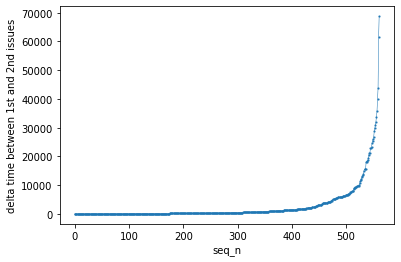

In [11]:
fig, ax = plt.subplots()
plt.xlabel("seq_n")
plt.ylabel("delta time between 1st and 2nd issues")
ax.plot(range(len(tmp_lst)),  tmp_lst, '-s', linewidth=0.5, markersize=1)

In [12]:
keys = list(contrib_cnt.keys())
for key in keys:
    if contrib_cnt[key] == 1 and int(df[df.resolver == key].resolver_commit_num) <= 1:
        if pd.to_datetime("2022-07-01 00:00:00") - df[df.resolver == key][-1:].closed_at.values[0] < dt:
            contrib_cnt.pop(key)
print(len(contrib_cnt))

1428


In [13]:
# 去除无法判别为otc或notc的数据
df = df[df.resolver.map(lambda x: x in contrib_cnt.keys())]

In [14]:
gfi, ngfi = df[df.resolver_commit_num <= 1], df[df.resolver_commit_num > 1]
# print(gfi)
len(df), len(gfi), len(ngfi)

(7528, 1531, 5997)

In [15]:
gfi = gfi.drop_duplicates("resolver", keep="first")
len(df), len(gfi), len(ngfi)

(7528, 1252, 5997)

In [10]:
# 将gfi存入文件
gfi.to_json("../data/pandas_gfi.json", orient='records', indent=2)

In [11]:
# 将以pr形式提交的gfi和以commit提交的gfi分别存入文件
# dataset1 = gfi[gfi.resolved_in.map(lambda x:isinstance(x, int))]
# dataset2 = gfi[gfi.resolved_in.map(lambda x:isinstance(x, str))]
# dataset1.to_json("../data/pandas_gfi_pr.json", orient='records', indent=2)
# dataset2.to_json("../data/pandas_gfi_commit.json", orient='records', indent=2)

In [22]:
# 文本部分处理
def count_code_snippets(s: str) -> int:
    p = re.compile(r"```.+?```", flags=re.S)
    if s is None:
        return 0
    return len(p.findall(s))


def delete_code_snippets(s: str) -> str:
    if s is None:
        return ""
    p = re.compile(r"```.+?```", flags=re.S)
    s = p.sub("", s)
    # return " ".join(s.split())
    return s


def count_urls(s: str) -> int:
    if s is None:
        return 0
    p = re.compile(r"http[:/\w\.]+")
    lst = list(
        filter(  # do not count images, this will be done in count_imgs()
            lambda s2: not (
                s2.endswith("jpg") or s2.endswith("jpeg") or s2.endswith("png")
            ),
            p.findall(s),
        )
    )
    return len(lst)


def delete_urls(s: str) -> str:
    if s == None:
        return ""
    p = re.compile(r"http[:/\w\.]+")
    s = p.sub("", s)
    # return " ".join(s.split())
    return s


def count_imgs(s: str) -> int:
    if s is None:
        return 0
    p = re.compile(r"http[:/\w\.]+")
    lst = list(
        filter(
            lambda s2: s2.endswith("jpg") or s2.endswith("jpeg") or s2.endswith("png"),
            p.findall(s),
        )
    )
    return len(lst)

def delete_imgs(s: str) -> str:
    if s is None:
        return ""
    p = re.compile(r"http[:/\w\.]+")
    filter(
        lambda s2: s2.endswith("jpg") or s2.endswith("jpeg") or s2.endswith("png"),
        p.findall(s),
    )
    
    s = p.sub("", s)
    # return " ".join(s.split())
    return s

def count_text_len(s: str) -> int:
    if s == None:
        return 0
    return len(s.split())


def get_categorized_labels(labels: list) -> dict:
    keyword_rules = {
        "bug": ["bug"],
        "feature": ["feature"],
        "test": ["test", "testing"],
        "build": ["ci", "build"],
        "doc": ["doc", "document", "documentation"],
        "coding": ["code", "coding", "program", "programming"],
        "enhance": ["enhance", "enhancement"],
        "gfi": [
            "easy",
            "starter",
            "newbie",
            "beginner",
            "starter",
            "minor",
            "novice",
            ("good", "first"),
            ("low", "fruit"),
            ("effort", "low"),
            ("first", "time"),
            ("first", "timer"),
            ("first", "pr"),
            ("up", "for", "grab"),
        ],
        "medium": ["medium", "intermediate"],
        "major": [
            "important",
            "major",
            "breaking",
            "difficult",
            "hard",
            "core",
            "serious",
            ("priority", "p1"),
            ("priority", "high"),
            ("priority", "critical"),
        ],
        "triaged": [
            "triaged",
            "triage",
            "progress",
            "haspr",
            "fixed",
            "wontfix",
            ("ha", "pr"),
            ("ha", "fix"),
        ],
        "untriaged": [
            "untriaged",
            ("need", "triage"),
            ("needed", "triage"),
            ("no", "triage"),
        ],
    }

    label_cat = Counter()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    for k in keyword_rules:
        label_cat[k] = 0
    for label in labels:
        words = re.compile(r"\w+").findall(label.lower().replace("_", " "))
        words = [lemmatizer.lemmatize(w) for w in words]
        for cat, rules in keyword_rules.items():
            match = 0
            for rule in rules:
                if isinstance(rule, (tuple, list)):
                    if all(word in words for word in rule):
                        match = 1
                elif rule in words:
                    match = 1
                elif any(rule in w for w in words):
                    match = 1
            label_cat[cat] += match
    return label_cat

def count_words(s):
    s = s.lower()
#     lst = word_tokenize(s)
#     interpunctuations = ['<','>\|+|\'+|\d|\`+|\#+|\s+|\,+|\.+|\!+|\:+|\?+|\;+|\(+|\)+|\-+|\_+|\=+|\++|\“+|\、+|\/+|\{+|\}+|\”+|\：+|\。+|\“+|\[+|\]+|\【+|\】+|\—+|\%+|\"+']
    lst = re.split('\<+|\>+|\|+|\'+|\d|\`+|\#+|\s+|\,+|\.+|\!+|\:+|\?+|\;+|\(+|\)+|\-+|\_+|\=+|\++|\“+|\、+|\/+|\{+|\}+|\”+|\：+|\。+|\“+|\[+|\]+|\【+|\】+|\—+|\%+|\"+',s)    
    diccount = {}
    cnt = 0
    for i in lst:
        if i == ' ' or i =='' or len(i)<=2:
            continue
        cnt += 1
        if i not in diccount:
            diccount[i] = 1  # 第一遍字典为空 赋值相当于 i=1，i为words里的单词
            # print(diccount)
        else:
            diccount[i] += 1    
#     print(diccount)
#     print(cnt)
    for key in diccount:
        diccount[key] = round(100*diccount[key]/cnt,2)
    return diccount

In [6]:
# 处理数据得到新feature
def data_analysis(dataset):
    tmpdf = dataset.copy(deep = True)
    tmpdf["clean_body"] = tmpdf.body.map(lambda s: delete_code_snippets(delete_code_snippets(s)))
    tmpdf["clean_body1"] = tmpdf.clean_body.map(lambda s: delete_imgs(delete_urls(s)))
    tmpdf["len_title"] = tmpdf.title.map(count_text_len)
    tmpdf["len_body"] = tmpdf.clean_body.map(count_text_len)
    tmpdf["n_code_snips"] = tmpdf.body.map(count_code_snippets)
    tmpdf["n_urls"] = tmpdf.body.map(count_urls)
    tmpdf["n_imgs"] = tmpdf.body.map(count_imgs)
    tmpdf["coleman_liau_index"] = tmpdf.clean_body.map(textstat.coleman_liau_index)
    tmpdf["flesch_reading_ease"] = tmpdf.clean_body.map(textstat.flesch_reading_ease)
    tmpdf["flesch_kincaid_grade"] = tmpdf.clean_body.map(textstat.flesch_kincaid_grade)
    tmpdf["automated_readability_index"] = tmpdf.clean_body.map(textstat.automated_readability_index)
    tmpdf["n_comments"] = tmpdf.comments.map(len)
    tmpdf["n_events"] = tmpdf.events.map(len)
    tmpdf["label_categories"] = tmpdf.labels.map(get_categorized_labels)
    return tmpdf

In [16]:
gfi = data_analysis(gfi)

otc_gfi = gfi[gfi.resolver.map(lambda r: contrib_cnt[r] == 1)]
notc_gfi = gfi[gfi.resolver.map(lambda r: contrib_cnt[r] > 1)]
len(otc_gfi), len(notc_gfi)

(803, 449)

In [12]:
metrics = [
    "len_title", "len_body", 
    #"n_code_snips", "n_urls", "n_imgs", 
    "coleman_liau_index", 
    #"flesch_reading_ease", "flesch_kincaid_grade", "automated_readability_index", 
    "n_comments", "n_events",
    "additions", "deletions", "changed_files"
]

In [13]:
otc_gfi[metrics].describe()

,len_title,len_body,coleman_liau_index,n_comments,n_events,additions,deletions,changed_files
count,803.000000,803.000000,803.000000,803.000000,803.000000,803.000000,803.000000,803.000000
mean,7.864259,124.748443,14.699701,4.600249,17.110834,49.880448,14.582814,3.457036
std,3.169014,122.465748,17.193402,4.634076,11.599893,138.451016,64.691954,5.580656
min,2.000000,0.000000,-22.210000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,6.000000,40.000000,9.800000,2.000000,10.000000,9.000000,1.000000,1.000000
50%,7.000000,92.000000,12.070000,3.000000,14.000000,22.000000,3.000000,3.000000
75%,10.000000,180.000000,15.180000,6.000000,21.500000,46.500000,9.000000,4.000000
max,28.000000,1630.000000,346.400000,32.000000,85.000000,2858.000000,1316.000000,85.000000


In [14]:
notc_gfi[metrics].describe()

,len_title,len_body,coleman_liau_index,n_comments,n_events,additions,deletions,changed_files
count,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000
mean,8.182628,126.563474,13.581670,4.563474,17.590200,74.247216,33.100223,3.714922
std,3.196337,101.613374,17.022839,5.009910,12.456227,206.005199,163.040793,4.000421
min,1.000000,0.000000,-33.810000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,6.000000,41.000000,9.600000,1.000000,9.000000,12.000000,1.000000,1.000000
50%,8.000000,108.000000,11.810000,3.000000,15.000000,24.000000,4.000000,3.000000
75%,10.000000,189.000000,14.030000,6.000000,22.000000,62.000000,17.000000,4.000000
max,21.000000,543.000000,296.800000,34.000000,89.000000,2991.000000,2874.000000,35.000000


In [15]:
for metric in metrics:
    print(f"{metric:30} {mannwhitneyu(notc_gfi[metric], otc_gfi[metric])}")

len_title                      MannwhitneyuResult(statistic=168534.0, pvalue=0.027228984942508992)
len_body                       MannwhitneyuResult(statistic=174944.5, pvalue=0.192573882183311)
coleman_liau_index             MannwhitneyuResult(statistic=168109.5, pvalue=0.023716691360060216)
n_comments                     MannwhitneyuResult(statistic=174522.0, pvalue=0.1728787662089798)
n_events                       MannwhitneyuResult(statistic=178993.5, pvalue=0.41734619907338144)
additions                      MannwhitneyuResult(statistic=161505.5, pvalue=0.0011088697936460295)
deletions                      MannwhitneyuResult(statistic=165072.0, pvalue=0.006298668907968021)
changed_files                  MannwhitneyuResult(statistic=168233.0, pvalue=0.021046762321652576)


In [16]:
list(map(
    lambda x: (x[0], x[1] / len(otc_gfi)), 
    sorted(Counter(sum(otc_gfi.labels, [])).items(), key=lambda x: -x[1])[0:20]
))

[('good first issue', 0.3001245330012453),
 ('Docs', 0.28019925280199254),
 ('Effort Low', 0.26650062266500624),
 ('Bug', 0.25529265255292655),
 ('Difficulty Novice', 0.14819427148194272),
 ('Reshaping', 0.0921544209215442),
 ('Difficulty Intermediate', 0.07970112079701121),
 ('Error Reporting', 0.07347447073474471),
 ('Enhancement', 0.0684931506849315),
 ('Needs Tests', 0.057285180572851806),
 ('Indexing', 0.05603985056039851),
 ('Timeseries', 0.0547945205479452),
 ('Groupby', 0.0448318804483188),
 ('API Design', 0.043586550435865505),
 ('Visualization', 0.04234122042341221),
 ('Effort Medium', 0.04234122042341221),
 ('Dtypes', 0.039850560398505604),
 ('Regression', 0.038605230386052306),
 ('Testing', 0.034869240348692404),
 ('MultiIndex', 0.033623910336239106)]

In [17]:
list(map(
    lambda x: (x[0], x[1] / len(notc_gfi)), 
    sorted(Counter(sum(notc_gfi.labels, [])).items(), key=lambda x: -x[1])[0:20]
))

[('Bug', 0.32516703786191536),
 ('good first issue', 0.3028953229398664),
 ('Effort Low', 0.23608017817371937),
 ('Docs', 0.18262806236080179),
 ('Difficulty Novice', 0.12694877505567928),
 ('Needs Tests', 0.111358574610245),
 ('Reshaping', 0.0957683741648107),
 ('Difficulty Intermediate', 0.0801781737193764),
 ('Groupby', 0.0645879732739421),
 ('Timeseries', 0.05790645879732739),
 ('Indexing', 0.053452115812917596),
 ('Error Reporting', 0.051224944320712694),
 ('MultiIndex', 0.04899777282850779),
 ('Enhancement', 0.04899777282850779),
 ('API Design', 0.042316258351893093),
 ('Effort Medium', 0.0400890868596882),
 ('Categorical', 0.0400890868596882),
 ('Dtypes', 0.0378619153674833),
 ('Numeric', 0.0378619153674833),
 ('Testing', 0.0378619153674833)]

In [18]:
counter = Counter()
for cat in otc_gfi.label_categories:
    counter.update(cat)
total = sum(counter.values())
for k, v in counter.items():
    counter[k] = v / total
counter

Counter({'bug': 0.1390773405698779,
         'feature': 0.0,
         'test': 0.050203527815468114,
         'build': 0.015603799185888738,
         'doc': 0.15264586160108548,
         'coding': 0.004070556309362279,
         'enhance': 0.03731343283582089,
         'gfi': 0.40027137042062416,
         'medium': 0.06716417910447761,
         'major': 0.12686567164179105,
         'triaged': 0.0033921302578018998,
         'untriaged': 0.0033921302578018998})

In [19]:
counter = Counter()
for cat in notc_gfi.label_categories:
    counter.update(cat)
total = sum(counter.values())
for k, v in counter.items():
    counter[k] = v / total
counter

Counter({'bug': 0.18341708542713567,
         'feature': 0.0,
         'test': 0.08417085427135679,
         'build': 0.016331658291457288,
         'doc': 0.10301507537688442,
         'coding': 0.001256281407035176,
         'enhance': 0.02763819095477387,
         'gfi': 0.38944723618090454,
         'medium': 0.06909547738693467,
         'major': 0.11809045226130653,
         'triaged': 0.0037688442211055275,
         'untriaged': 0.0037688442211055275})

In [20]:
y = gfi.resolver.map(lambda r: contrib_cnt[r] > 1)
X = gfi[metrics]
log_reg = sm.Logit(y, X).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.654035
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               resolver   No. Observations:                 1252
Model:                          Logit   Df Residuals:                     1244
Method:                           MLE   Df Model:                            7
Date:                Fri, 12 Aug 2022   Pseudo R-squ.:               -0.002163
Time:                        20:24:57   Log-Likelihood:                -818.85
converged:                       True   LL-Null:                       -817.08
Covariance Type:            nonrobust   LLR p-value:                     1.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
len_title             -0.0221      0.015     -1.518      0.129      -0.051       0.006
len_body              -0.0003      0.001     -0.558      0.577      -0.001       0.001
coleman_liau_index    -0.0130      0.006     -2.351      0.019      -0.024      -0.002
n_comments            -0.0196      0.023     -0.838      0.402      -0.066       0.026
n_events              -0.0011      0.009     -0.119      0.905      -0.019       0.016
additions              0.0003      0.001      0.544      0.586      -0.001       0.001
deletions              0.0022      0.001      1.824      0.068      -0.000       0.005
changed_files         -0.0185      0.015     -1.246      0.213      -0.047       0.011
======================================================================================
"""

[('none', 7.79), ('the', 4.36), ('pandas', 2.65), ('this', 1.27), ('python', 1.07), ('and', 0.98), ('output', 0.97), ('that', 0.88), ('versions', 0.84), ('for', 0.79), ('details', 0.78), ('with', 0.73), ('not', 0.73), ('code', 0.62), ('problem', 0.59), ('html', 0.56), ('lib', 0.54), ('all', 0.52), ('example', 0.51), ('expected', 0.49), ('show', 0.48), ('utf', 0.47), ('have', 0.45), ('description', 0.44), ('dataframe', 0.43), ('numpy', 0.43), ('xlsxwriter', 0.42), ('but', 0.41), ('lxml', 0.41), ('when', 0.4), ('sample', 0.4), ('should', 0.39), ('matplotlib', 0.39), ('are', 0.38), ('ipython', 0.38), ('commit', 0.38), ('installed', 0.37), ('scipy', 0.37), ('file', 0.37), ('release', 0.37), ('index', 0.36), ('pip', 0.36), ('cython', 0.36), ('numexpr', 0.36), ('line', 0.36), ('dateutil', 0.36), ('tables', 0.36), ('openpyxl', 0.36), ('sqlalchemy', 0.36), ('bits', 0.35), ('bottleneck', 0.35), ('final', 0.35), ('machine', 0.35), ('little', 0.35), ('sphinx', 0.35), ('pytz', 0.35), ('xlrd', 0.35

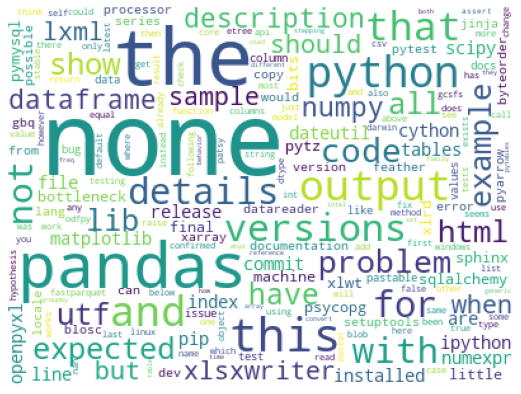

In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(s):
    s = s.lower()
    wordcloud = WordCloud(background_color="white",\
                      width = 400,\
                      height = 300,\
                      max_font_size = 80,\
                      contour_width = 3,\
                      contour_color = 'steelblue'
#                       ).generate(s)
                      ).generate_from_frequencies(dic1)
    plt.figure(figsize=(13,7))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
s1 = otc_gfi["clean_body1"].sum().lower()
# print(s1)

dic1 = count_words(s1)
dic11 = sorted(dic1.items(),key=lambda d:d[1],reverse=True)
print(dic11[0:100])

plot_word_cloud(s1)

[('none', 8.43), ('the', 4.24), ('pandas', 3.4), ('this', 1.39), ('output', 1.05), ('and', 0.99), ('python', 0.95), ('versions', 0.95), ('details', 0.82), ('that', 0.78), ('for', 0.74), ('core', 0.72), ('code', 0.7), ('with', 0.68), ('not', 0.66), ('have', 0.57), ('problem', 0.56), ('example', 0.55), ('expected', 0.55), ('dev', 0.55), ('all', 0.54), ('show', 0.52), ('master', 0.5), ('html', 0.5), ('utf', 0.5), ('xlsxwriter', 0.45), ('dataframe', 0.45), ('lxml', 0.45), ('numpy', 0.44), ('description', 0.43), ('series', 0.42), ('sample', 0.41), ('blob', 0.41), ('when', 0.4), ('should', 0.4), ('commit', 0.4), ('release', 0.4), ('cython', 0.4), ('but', 0.39), ('matplotlib', 0.39), ('pytz', 0.39), ('installed', 0.39), ('scipy', 0.39), ('lib', 0.39), ('xlwt', 0.38), ('openpyxl', 0.38), ('dateutil', 0.38), ('machine', 0.38), ('ipython', 0.38), ('sphinx', 0.38), ('bottleneck', 0.38), ('tables', 0.38), ('numexpr', 0.38), ('xlrd', 0.38), ('sqlalchemy', 0.38), ('pymysql', 0.38), ('psycopg', 0.38)

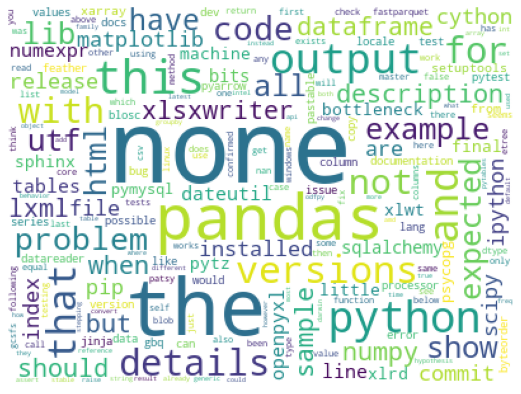

In [24]:
s2 = notc_gfi["clean_body1"].sum().lower()
dic2 = count_words(s2)
dic22 = sorted(dic2.items(),key=lambda d:d[1],reverse=True)
print(dic22[0:100])

plot_word_cloud(s2)

In [24]:
list(map(
    lambda x: (x[0], x[1] / len(otc_gfi)), 
    sorted(Counter(sum(otc_gfi.events, [])).items(), key=lambda x: -x[1])[0:20]
))

[('commented', 4.597758405977584),
 ('labeled', 3.161892901618929),
 ('milestoned', 1.5865504358655043),
 ('subscribed', 1.5740971357409714),
 ('cross-referenced', 1.547945205479452),
 ('mentioned', 1.5429638854296388),
 ('referenced', 1.5068493150684932),
 ('demilestoned', 0.7210460772104608),
 ('unlabeled', 0.3723536737235367),
 ('renamed', 0.21544209215442092),
 ('assigned', 0.14694894146948942),
 ('closed', 0.053549190535491904),
 ('reopened', 0.049813200498132),
 ('unassigned', 0.019925280199252802),
 ('unsubscribed', 0.0049813200498132005),
 ('added_to_project', 0.0037359900373599006),
 ('connected', 0.0024906600249066002),
 ('marked_as_duplicate', 0.0012453300124533001),
 ('disconnected', 0.0012453300124533001)]

In [25]:
list(map(
    lambda x: (x[0], x[1] / len(notc_gfi)), 
    sorted(Counter(sum(notc_gfi.events, [])).items(), key=lambda x: -x[1])[0:20]
))

[('commented', 4.55456570155902),
 ('labeled', 3.282850779510022),
 ('referenced', 1.7951002227171493),
 ('cross-referenced', 1.6302895322939865),
 ('milestoned', 1.55456570155902),
 ('mentioned', 1.5189309576837418),
 ('subscribed', 1.5189309576837418),
 ('demilestoned', 0.6926503340757239),
 ('unlabeled', 0.5189309576837416),
 ('renamed', 0.21603563474387527),
 ('assigned', 0.16926503340757237),
 ('closed', 0.062360801781737196),
 ('reopened', 0.053452115812917596),
 ('unassigned', 0.011135857461024499),
 ('unsubscribed', 0.0066815144766146995),
 ('added_to_project', 0.004454342984409799)]

In [27]:
df1 = pd.read_json("../data/pandas_gfi_pr.json")
otc_pr = df1[df1.resolver.map(lambda r: contrib_cnt[r] == 1)]
notc_pr = df1[df1.resolver.map(lambda r: contrib_cnt[r] > 1)]
len(otc_pr), len(notc_pr)

(699, 389)

In [28]:
df2 = pd.read_json("../data/pandas_gfi_commit.json")
otc_commit = df2[df2.resolver.map(lambda r: contrib_cnt[r] == 1)]
notc_commit = df2[df2.resolver.map(lambda r: contrib_cnt[r] > 1)]
len(otc_commit), len(notc_commit)

(104, 60)

In [29]:
list(map(
    lambda x: (x[0], x[1] / len(otc_pr)), 
    sorted(Counter(sum(otc_pr.events, [])).items(), key=lambda x: -x[1])[0:20]
))

[('commented', 4.563662374821173),
 ('labeled', 3.0944206008583692),
 ('subscribed', 1.5693848354792561),
 ('milestoned', 1.5550786838340487),
 ('mentioned', 1.5464949928469243),
 ('cross-referenced', 1.5336194563662375),
 ('referenced', 1.4792560801144492),
 ('demilestoned', 0.698140200286123),
 ('unlabeled', 0.41630901287553645),
 ('renamed', 0.21316165951359084),
 ('assigned', 0.16738197424892703),
 ('closed', 0.05150214592274678),
 ('reopened', 0.04721030042918455),
 ('unassigned', 0.022889842632331903),
 ('unsubscribed', 0.005722460658082976),
 ('added_to_project', 0.004291845493562232),
 ('connected', 0.002861230329041488),
 ('marked_as_duplicate', 0.001430615164520744),
 ('disconnected', 0.001430615164520744)]

In [30]:
list(map(
    lambda x: (x[0], x[1] / len(notc_pr)), 
    sorted(Counter(sum(notc_pr.events, [])).items(), key=lambda x: -x[1])[0:20]
))

[('commented', 4.596401028277635),
 ('labeled', 3.2596401028277633),
 ('cross-referenced', 1.6580976863753214),
 ('referenced', 1.544987146529563),
 ('mentioned', 1.5424164524421593),
 ('subscribed', 1.5398457583547558),
 ('milestoned', 1.5372750642673523),
 ('demilestoned', 0.6786632390745502),
 ('unlabeled', 0.5861182519280206),
 ('renamed', 0.2133676092544987),
 ('assigned', 0.1928020565552699),
 ('closed', 0.05912596401028278),
 ('reopened', 0.04884318766066838),
 ('unassigned', 0.012853470437017995),
 ('unsubscribed', 0.007712082262210797),
 ('added_to_project', 0.005141388174807198)]

In [31]:
list(map(
    lambda x: (x[0], x[1] / len(otc_commit)), 
    sorted(Counter(sum(otc_commit.events, [])).items(), key=lambda x: -x[1])[0:20]
))

[('commented', 4.826923076923077),
 ('labeled', 3.6153846153846154),
 ('milestoned', 1.7980769230769231),
 ('referenced', 1.6923076923076923),
 ('cross-referenced', 1.6442307692307692),
 ('subscribed', 1.6057692307692308),
 ('mentioned', 1.5192307692307692),
 ('demilestoned', 0.875),
 ('renamed', 0.23076923076923078),
 ('unlabeled', 0.07692307692307693),
 ('closed', 0.0673076923076923),
 ('reopened', 0.0673076923076923),
 ('assigned', 0.009615384615384616)]

In [32]:
list(map(
    lambda x: (x[0], x[1] / len(notc_commit)), 
    sorted(Counter(sum(notc_commit.events, [])).items(), key=lambda x: -x[1])[0:20]
))

[('commented', 4.283333333333333),
 ('labeled', 3.433333333333333),
 ('referenced', 3.4166666666666665),
 ('milestoned', 1.6666666666666667),
 ('cross-referenced', 1.45),
 ('subscribed', 1.3833333333333333),
 ('mentioned', 1.3666666666666667),
 ('demilestoned', 0.7833333333333333),
 ('renamed', 0.23333333333333334),
 ('unlabeled', 0.08333333333333333),
 ('closed', 0.08333333333333333),
 ('reopened', 0.08333333333333333),
 ('assigned', 0.016666666666666666)]

In [33]:
# otc_commit.changed_files_list
list(map(
    lambda x: (x[0], x[1] / len(otc_commit)), 
    sorted(Counter(sum(otc_commit.changed_files_list, [])).items(), key=lambda x: -x[1])[0:20]
))

AttributeError: 'DataFrame' object has no attribute 'changed_files_list'

In [38]:
# notc_commit.changed_files_list
list(map(
    lambda x: (x[0], x[1] / len(notc_commit)), 
    sorted(Counter(sum(notc_commit.changed_files_list, [])).items(), key=lambda x: -x[1])[0:20]
))

[('doc/source/whatsnew/v0.20.0.txt', 0.3),
 ('doc/source/whatsnew/v0.19.0.txt', 0.15),
 ('doc/source/whatsnew/v0.18.1.txt', 0.13333333333333333),
 ('pandas/core/frame.py', 0.1),
 ('pandas/core/generic.py', 0.1),
 ('doc/source/whatsnew/v0.18.2.txt', 0.1),
 ('pandas/indexes/base.py', 0.08333333333333333),
 ('doc/source/whatsnew/v0.18.0.txt', 0.06666666666666667),
 ('pandas/core/groupby.py', 0.06666666666666667),
 ('pandas/tools/pivot.py', 0.05),
 ('pandas/tools/tests/test_pivot.py', 0.05),
 ('pandas/core/strings.py', 0.05),
 ('pandas/tests/test_strings.py', 0.05),
 ('pandas/tests/test_reshape.py', 0.05),
 ('pandas/tseries/tests/test_timedeltas.py', 0.05),
 ('pandas/tslib.pyx', 0.05),
 ('pandas/core/internals.py', 0.05),
 ('pandas/tests/test_categorical.py', 0.05),
 ('pandas/tests/test_groupby.py', 0.05),
 ('pandas/core/categorical.py', 0.05)]

In [24]:
sum(otc_commit.changed_files) / len(otc_commit),sum(notc_commit.changed_files) / len(notc_commit),

(3.8476190476190477, 4.566666666666666)

In [34]:
otc_pr = data_analysis(otc_pr)
notc_pr = data_analysis(notc_pr)
otc_commit = data_analysis(otc_commit)
notc_commit = data_analysis(notc_commit)

In [35]:
for metric in metrics:
    print(f"{metric:30} {mannwhitneyu(notc_pr[metric], otc_pr[metric])}")

len_title                      MannwhitneyuResult(statistic=127054.0, pvalue=0.03584584779219321)
len_body                       MannwhitneyuResult(statistic=131604.5, pvalue=0.19056750086626867)
coleman_liau_index             MannwhitneyuResult(statistic=121460.5, pvalue=0.0017621024882786087)
n_comments                     MannwhitneyuResult(statistic=131802.5, pvalue=0.2002556681330775)
n_events                       MannwhitneyuResult(statistic=135397.5, pvalue=0.4552872305981456)
additions                      MannwhitneyuResult(statistic=121937.0, pvalue=0.0023812094989068976)
deletions                      MannwhitneyuResult(statistic=123832.0, pvalue=0.006972068361228041)
changed_files                  MannwhitneyuResult(statistic=126865.5, pvalue=0.028781002260158683)


In [36]:
for metric in metrics:
    print(f"{metric:30} {mannwhitneyu(notc_commit[metric], otc_commit[metric])}")

len_title                      MannwhitneyuResult(statistic=2928.0, pvalue=0.25530325858485614)
len_body                       MannwhitneyuResult(statistic=3014.5, pvalue=0.35999008231803764)
coleman_liau_index             MannwhitneyuResult(statistic=2586.5, pvalue=0.034405269556807797)
n_comments                     MannwhitneyuResult(statistic=2995.5, pvalue=0.334675102450833)
n_events                       MannwhitneyuResult(statistic=3010.0, pvalue=0.35414307533720213)
additions                      MannwhitneyuResult(statistic=2763.5, pvalue=0.1120777234537686)
deletions                      MannwhitneyuResult(statistic=3023.5, pvalue=0.37090794139751837)
changed_files                  MannwhitneyuResult(statistic=3006.0, pvalue=0.3436092777733239)


In [37]:
otc_pr[metrics].describe()

,len_title,len_body,coleman_liau_index,n_comments,n_events,additions,deletions,changed_files
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,7.928469,129.814020,15.079485,4.563662,16.974249,46.924177,14.782546,3.400572
std,3.214050,124.892755,18.141829,4.486835,11.454378,139.930381,67.875064,5.861320
min,2.000000,0.000000,-22.210000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,6.000000,42.500000,9.980000,2.000000,10.000000,8.000000,1.000000,1.000000
50%,7.000000,102.000000,12.260000,4.000000,14.000000,21.000000,2.000000,3.000000
75%,10.000000,188.500000,15.605000,6.000000,21.000000,44.000000,8.000000,3.000000
max,28.000000,1630.000000,346.400000,32.000000,85.000000,2858.000000,1316.000000,85.000000


In [38]:
notc_pr[metrics].describe()

,len_title,len_body,coleman_liau_index,n_comments,n_events,additions,deletions,changed_files
count,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000
mean,8.233933,132.005141,13.644679,4.598972,17.483290,70.401028,33.827763,3.583548
std,3.162975,103.145228,18.075091,5.071001,12.606979,202.813912,173.110785,3.822928
min,1.000000,0.000000,-33.810000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,6.000000,45.000000,9.660000,1.000000,9.000000,12.000000,1.000000,1.000000
50%,8.000000,114.000000,11.700000,3.000000,14.000000,23.000000,3.000000,3.000000
75%,10.000000,201.000000,13.940000,6.000000,22.000000,60.000000,17.000000,4.000000
max,18.000000,543.000000,296.800000,34.000000,89.000000,2991.000000,2874.000000,32.000000


In [53]:
sum(map(lambda x: x.timestamp(), otc_pr.closed_at)) / len(otc_pr), sum(map(lambda x: x.timestamp(), notc_pr.closed_at)) / len(notc_pr)

(1556171924.8403041, 1545239452.3444731)

In [55]:
sum(map(lambda x: x.timestamp(), otc_commit.closed_at)) / len(otc_commit), sum(map(lambda x: x.timestamp(), notc_commit.closed_at)) / len(notc_commit)

(1469191386.2476192, 1471285566.5)

In [56]:
list(map(
    lambda x: (x[0], x[1] / len(otc_pr)), 
    sorted(Counter(sum(otc_pr.labels, [])).items(), key=lambda x: -x[1])[0:20]
))

[('good first issue', 0.35361216730038025),
 ('Docs', 0.2953105196451204),
 ('Bug', 0.2572877059569075),
 ('Effort Low', 0.19771863117870722),
 ('Difficulty Novice', 0.09125475285171103),
 ('Reshaping', 0.08365019011406843),
 ('Needs Tests', 0.08365019011406843),
 ('Error Reporting', 0.06590621039290241),
 ('Enhancement', 0.062103929024081114),
 ('Difficulty Intermediate', 0.05576679340937896),
 ('Timeseries', 0.05449936628643853),
 ('Indexing', 0.05449936628643853),
 ('Groupby', 0.053231939163498096),
 ('Visualization', 0.046894803548795945),
 ('Regression', 0.043092522179974654),
 ('API Design', 0.035487959442332066),
 ('Testing', 0.034220532319391636),
 ('Dtypes', 0.034220532319391636),
 ('MultiIndex', 0.034220532319391636),
 ('IO Excel', 0.031685678073510776)]

In [57]:
list(map(
    lambda x: (x[0], x[1] / len(notc_pr)), 
    sorted(Counter(sum(notc_pr.labels, [])).items(), key=lambda x: -x[1])[0:20]
))

[('good first issue', 0.3496143958868895),
 ('Bug', 0.2930591259640103),
 ('Docs', 0.19794344473007713),
 ('Effort Low', 0.18251928020565553),
 ('Needs Tests', 0.12853470437017994),
 ('Reshaping', 0.08226221079691516),
 ('Difficulty Novice', 0.07197943444730077),
 ('Difficulty Intermediate', 0.06940874035989718),
 ('Groupby', 0.061696658097686374),
 ('MultiIndex', 0.05398457583547558),
 ('Enhancement', 0.05398457583547558),
 ('Indexing', 0.05398457583547558),
 ('Timeseries', 0.05141388174807198),
 ('Error Reporting', 0.04884318766066838),
 ('Testing', 0.04113110539845758),
 ('API Design', 0.038560411311053984),
 ('Effort Medium', 0.038560411311053984),
 ('Categorical', 0.03598971722365039),
 ('Clean', 0.03598971722365039),
 ('Numeric', 0.033419023136246784)]

In [58]:
list(map(
    lambda x: (x[0], x[1] / len(otc_commit)), 
    sorted(Counter(sum(otc_commit.labels, [])).items(), key=lambda x: -x[1])[0:20]
))

[('Effort Low', 0.5523809523809524),
 ('Difficulty Novice', 0.44761904761904764),
 ('Bug', 0.3619047619047619),
 ('Difficulty Intermediate', 0.19047619047619047),
 ('Docs', 0.1619047619047619),
 ('Reshaping', 0.13333333333333333),
 ('Enhancement', 0.09523809523809523),
 ('Error Reporting', 0.09523809523809523),
 ('Effort Medium', 0.08571428571428572),
 ('Compat', 0.08571428571428572),
 ('Dtypes', 0.0761904761904762),
 ('Timeseries', 0.0761904761904762),
 ('Missing-data', 0.0761904761904762),
 ('API Design', 0.06666666666666667),
 ('Good as first PR', 0.05714285714285714),
 ('Groupby', 0.05714285714285714),
 ('CSV', 0.05714285714285714),
 ('Categorical', 0.05714285714285714),
 ('Indexing', 0.05714285714285714),
 ('Unicode', 0.047619047619047616)]

In [59]:
list(map(
    lambda x: (x[0], x[1] / len(notc_commit)), 
    sorted(Counter(sum(notc_commit.labels, [])).items(), key=lambda x: -x[1])[0:20]
))

[('Effort Low', 0.5833333333333334),
 ('Bug', 0.5333333333333333),
 ('Difficulty Novice', 0.48333333333333334),
 ('Reshaping', 0.18333333333333332),
 ('Difficulty Intermediate', 0.15),
 ('Timeseries', 0.1),
 ('Docs', 0.08333333333333333),
 ('Groupby', 0.08333333333333333),
 ('Dtypes', 0.08333333333333333),
 ('API Design', 0.06666666666666667),
 ('Numeric', 0.06666666666666667),
 ('Categorical', 0.06666666666666667),
 ('Error Reporting', 0.06666666666666667),
 ('Deprecate', 0.05),
 ('Effort Medium', 0.05),
 ('Strings', 0.05),
 ('Compat', 0.05),
 ('Indexing', 0.05),
 ('IO HDF5', 0.05),
 ('CSV', 0.03333333333333333)]

In [64]:
sum(otc_pr.commit_num) / len(otc_pr), sum(notc_pr.commit_num) / len(notc_pr)

(6.7959442332065905, 6.298200514138817)

In [62]:
print(mannwhitneyu(notc_pr.commit_num, otc_pr.commit_num))

MannwhitneyuResult(statistic=141068.0, pvalue=0.011101657572032764)


In [22]:
otc_pr.changed_files_list

1       [{'file_name': 'pandas/tests/test_graphics.py'...
2       [{'file_name': 'pandas/io/sql.py', 'file_addit...
4       [{'file_name': 'setup.py', 'file_additions': 5...
6       [{'file_name': 'doc/source/release.rst', 'file...
7       [{'file_name': 'doc/source/release.rst', 'file...
                              ...                        
1063    [{'file_name': 'pandas/tests/reshape/merge/tes...
1064    [{'file_name': 'pandas/tests/indexing/multiind...
1065    [{'file_name': 'pandas/core/frame.py', 'file_a...
1066    [{'file_name': 'doc/source/whatsnew/v1.4.0.rst...
1067    [{'file_name': 'pandas/io/excel/_base.py', 'fi...
Name: changed_files_list, Length: 699, dtype: object

In [32]:
file_add_cnt1 = otc_pr.changed_files_list.map(lambda lst: sum(dic["file_additions"] for dic in lst)/len(lst) if len(lst) > 0 else 0)
print(sum(file_add_cnt1) / len(otc_pr))
file_add_cnt2 = notc_pr.changed_files_list.map(lambda lst: sum(dic["file_additions"] for dic in lst)/len(lst) if len(lst) > 0 else 0)
print(sum(file_add_cnt2) / len(notc_pr))

13.179017095814988
17.70374491065031


In [33]:
print(mannwhitneyu(file_add_cnt1, file_add_cnt2))

MannwhitneyuResult(statistic=122200.0, pvalue=0.0028045641334100537)


In [54]:
print(file_add_cnt1.corr(otc_pr.commit_num))
print(file_add_cnt2.corr(notc_pr.commit_num))

0.22323997239915683
0.06129130062456233


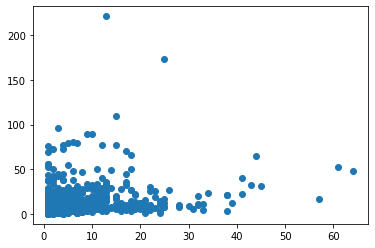

In [51]:
fig, ax = plt.subplots()
# plt.xlabel("seq_n")
# plt.ylabel("delta time between 1st and 2nd issues")
ax.scatter(list(otc_pr.commit_num), list(file_add_cnt1))

In [14]:
file_dele_cnt1 = otc_pr.changed_files_list.map(lambda lst: sum(dic["file_deletions"] for dic in lst)/len(lst) if len(lst) > 0 else 0)
print(sum(file_dele_cnt1) / len(otc_pr))
file_dele_cnt2 = notc_pr.changed_files_list.map(lambda lst: sum(dic["file_deletions"] for dic in lst)/len(lst) if len(lst) > 0 else 0)
print(sum(file_dele_cnt2) / len(notc_pr))

4.036476547569877
7.2602553873734745


In [15]:
print(mannwhitneyu(file_dele_cnt1, file_dele_cnt2))

MannwhitneyuResult(statistic=128255.5, pvalue=0.05981892091455399)


In [16]:
print(file_dele_cnt1.corr(otc_pr.commit_num))
print(file_dele_cnt2.corr(notc_pr.commit_num))

0.09135687158086697
0.0002741292665201577


In [17]:
file_add_cnt11 = otc_pr.changed_files_list.map(lambda lst: sum(dic["file_additions"] for dic in lst))
print(sum(file_add_cnt11) / len(otc_pr))
file_add_cnt22 = notc_pr.changed_files_list.map(lambda lst: sum(dic["file_additions"] for dic in lst))
print(sum(file_add_cnt22) / len(notc_pr))

46.9241773962804
70.40102827763496


In [18]:
print(mannwhitneyu(file_add_cnt11, file_add_cnt22))

MannwhitneyuResult(statistic=121937.0, pvalue=0.0023812094989069)


In [19]:
print(file_add_cnt11.corr(otc_pr.commit_num))
print(file_add_cnt22.corr(notc_pr.commit_num))

0.2420286044502179
0.06138998031872673


In [20]:
file_dele_cnt11 = otc_pr.changed_files_list.map(lambda lst: sum(dic["file_deletions"] for dic in lst))
print(sum(file_dele_cnt11) / len(otc_pr))
file_dele_cnt22 = notc_pr.changed_files_list.map(lambda lst: sum(dic["file_deletions"] for dic in lst))
print(sum(file_dele_cnt22) / len(notc_pr))

14.782546494992847
33.82776349614396


In [21]:
print(mannwhitneyu(file_dele_cnt11, file_dele_cnt22))

MannwhitneyuResult(statistic=123832.0, pvalue=0.006972068361228041)


In [22]:
print(file_dele_cnt11.corr(otc_pr.commit_num))
print(file_dele_cnt22.corr(notc_pr.commit_num))

0.13871991905808348
-0.012273862993635363


In [39]:
otc_pr_files = otc_pr.changed_files_list.map(lambda lst: list(dic["file_name"] for dic in lst))
tmp = []
for item in otc_pr_files:
    tmp.extend(item)
otc_pr_files = tmp
test_cnt1 = 0
doc_cnt1 = 0
core_cnt1 = 0
for i in otc_pr_files:
    if "tests" in i:
        test_cnt1 += 1
    elif "doc" in i:
        doc_cnt1 += 1
    elif "core" in i:
        core_cnt1 += 1
print(test_cnt1 / len(otc_pr_files), doc_cnt1 / len(otc_pr_files), core_cnt1 / len(otc_pr_files))
# file_add_cnt2 = notc_pr.changed_files_list.map(lambda lst: list(dic["file_additions"] for dic in lst)/len(lst) if len(lst) > 0 else 0)
# print(sum(file_add_cnt2) / len(notc_pr))

0.2814472023559108 0.2978544383676904 0.2149768615902398


In [29]:
otc_pr_files

['pandas/tests/test_graphics.py',
 'pandas/tools/plotting.py',
 'pandas/io/sql.py',
 'pandas/io/tests/test_sql.py',
 'setup.py',
 'doc/source/release.rst',
 'pandas/core/series.py',
 'pandas/tests/test_series.py',
 'doc/source/release.rst',
 'doc/source/v0.13.0.txt',
 'pandas/tests/test_graphics.py',
 'doc/source/release.rst',
 'pandas/io/tests/test_parsers.py',
 'pandas/parser.pyx',
 'doc/source/release.rst',
 'pandas/core/index.py',
 'pandas/tests/test_index.py',
 'pandas/tseries/period.py',
 'doc/source/release.rst',
 'pandas/core/frame.py',
 'pandas/tests/test_frame.py',
 'doc/source/release.rst',
 'pandas/tests/test_graphics.py',
 'pandas/tools/plotting.py',
 'pandas/core/internals.py',
 'pandas/io/parsers.py',
 'pandas/io/tests/test_parsers.py',
 'pandas/lib.pyx',
 'pandas/src/util.pxd',
 'pandas/tests/test_common.py',
 'doc/source/release.rst',
 'pandas/tseries/offsets.py',
 'pandas/tseries/tests/test_offsets.py',
 'doc/source/release.rst',
 'pandas/algos.pyx',
 'pandas/stats/te

In [40]:
notc_pr_files = notc_pr.changed_files_list.map(lambda lst: list(dic["file_name"] for dic in lst))
tmp = []
for item in notc_pr_files:
    tmp.extend(item)
notc_pr_files = tmp
test_cnt2 = 0
doc_cnt2 = 0
core_cnt2 = 0
for i in notc_pr_files:
    if "tests" in i:
        test_cnt2 += 1
    elif "doc" in i:
        doc_cnt2 += 1
    elif "core" in i:
        core_cnt2 += 1
print(test_cnt2 / len(notc_pr_files), doc_cnt2 / len(notc_pr_files), core_cnt2 / len(notc_pr_files))

0.3242467718794835 0.2302725968436155 0.22381635581061693
